In [42]:
import h5py 
import re
import unicodedata
from collections import defaultdict
from typing import List, Tuple, Dict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

## Util Functions

In [54]:
def stop_word_reader(file_path):
    try:
       with open(file_path, 'r', encoding='utf-8') as file:
            stop_words = [
                word.strip().strip('"')  # Remove whitespace and quotes
                for line in file
                for word in line.split(',')  # Split by commas
                if word.strip()  # Ignore empty words
            ]
       return stop_words
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
        return []  # Return an empty list if the file is not found
    except Exception as e:
        print(f"Error reading stop words: {e}")
        return []  # Return an empty list in case of any other exception
def hdf5_data_loader(chunk_size, start_index=0):
    file_path = 'dataset/GPAC_data.h5'
    dataset_name = 'text_data'
    with h5py.File(file_path, 'r') as hdf:
        dataset = hdf[dataset_name]
        if isinstance(dataset, h5py.Dataset):
            if hasattr(dataset, 'shape'):
                # In this case, the shape will be (num_chunks, sentences_per_chunk)
                total_chunks = dataset.shape[0]  # Number of chunks in the dataset
                sentences_per_chunk = dataset.shape[1]  # Sentences per chunk (e.g., 10 sentences)
            else:
                raise ValueError(f"Dataset '{dataset_name}' does not have a shape attribute.")
        else:
            raise TypeError(f"Dataset '{dataset_name}' is not a valid h5py.Dataset.")
        
        # Calculate the end index, making sure it's within bounds
        end_index = min(start_index + chunk_size, total_chunks)
        
        # Read the chunk of data (in this case, we are selecting rows from the first dimension)
        chunk_data = dataset[start_index:end_index]  # This retrieves a chunk of sentences
        
        # Flatten the chunk data if you want to read sentence-by-sentence
        # You can also choose to read smaller chunks from the existing 10-sentence chunks
        chunk_data_decoded = []
        
        for chunk in chunk_data:
            # Read only the first 2 sentences per chunk or any subset of sentences
            chunk_data_decoded.extend([sentence.decode('utf-8') for sentence in chunk[:chunk_size]])

        # Return the decoded chunk data and the new end index
        return total_chunks,chunk_data_decoded, end_index
def calculate_sentence_probability(sentence_ngrams,ngrams):
        sentence_prob = 1.0
        for ngram, count in sentence_ngrams.get_ngrams().items():
            print(ngram)
            if ngram in ngrams.probabilities():
              
                print(ngrams.probabilities())
                sentence_prob *= ngrams.probabilities().get(ngram) ** count  # Multiply with probability for each occurrence of the ngram
            else:
                sentence_prob *= 0  # If n-gram not found in the probabilities, assume probability 0
        return sentence_prob

## Classes 

In [44]:
class NGram:
    tokens: List[str]
    def __init__(self,n:int):
        self.n=n
        self._ngram_dict = None
        self._ngram_probabilities = None

    def generate(self) -> None:
        ngram_dict = defaultdict(int)
        for i in range(len(NGram.tokens) - self.n + 1):
            ngram = tuple(NGram.tokens[i:i + self.n])
            ngram_dict[ngram] += 1
        self._ngram_dict = dict(ngram_dict)
        self._ngram_probabilities = None  # Invalidate probabilities if n-grams change
    
    def get_ngrams(self):
        return self._ngram_dict
    
    def _calculate_probabilities(self) -> None:
        if self._ngram_dict is None:
            raise ValueError("N-grams have not been generated. Call `generate()` first.")
        total_count = sum(self._ngram_dict.values())
        self._ngram_probabilities = {
            ngram: count / total_count for ngram, count in self._ngram_dict.items()
        }
    
    def probabilities(self) -> Dict[Tuple[str, ...], float]:
        if self._ngram_probabilities is None:
            self._calculate_probabilities()
        return self._ngram_probabilities
    
    def conditional_probabilities(self) -> Dict[Tuple[str, ...], float]:
        if self._ngram_dict is None:
            raise ValueError("N-grams have not been generated. Call `generate()` first.")   
        conditional_probs = defaultdict(float)
        prefix_dict = defaultdict(int)
        for ngram, count in self._ngram_dict.items():
            if len(ngram) > 1:
                prefix = ngram[:-1]
                prefix_dict[prefix] += 1
        for ngram, count in self._ngram_dict.items():
            if len(ngram) > 1:
                prefix = ngram[:-1]
                prefix_count = prefix_dict.get(prefix, 0)
                # print(f"prefix count {prefix}:{prefix_count}")
                if prefix_count > 0:
                    conditional_probs[ngram] = count / prefix_count
                else:
                    conditional_probs[ngram] = 0.0  # In case prefix is not found

        return conditional_probs
    
    def top_frequencies(self, top_k: int) -> List[Tuple[Tuple[str, ...], int]]:
        if self._ngram_dict is None:
            raise ValueError("N-grams have not been generated. Call `generate()` first.")
        return sorted(self._ngram_dict.items(), key=lambda item: item[1], reverse=True)[:top_k]
    
    def display(self,size) -> None:
        if self._ngram_dict is None:
            raise ValueError("N-grams have not been generated. Call `generate()` first.")
        for idx, (ngram, freq) in enumerate(self._ngram_dict.items()):
            if idx >= size:  # Stop after displaying the first 10 items
                break
            print(f"{' '.join(ngram)}: {freq}")
    
    def display_conditional_probabilities(self,size) -> None:
        conditional_probs = self.conditional_probabilities()
        for idx, (ngram, prob) in enumerate(conditional_probs.items()):
            if idx >= size:  # Stop after displaying the first 10 items
                break
            prefix = ' '.join(ngram[:-1])
            word = ngram[-1]
            print(f"P({word} | {prefix}) = {prob:.4f}")
        # for ngram, prob in conditional_probs.items():
        #     prefix = ' '.join(ngram[:-1])
        #     word = ngram[-1]
        #     print(f"P({word} | {prefix}) = {prob:.4f}")
    
    def create_wordcloud(self, title):
        if self._ngram_dict is None:
            raise ValueError("N-grams have not been generated. Call `generate()` first.")
        font_path="amharic_font.ttf"
        ngram_freq = {" ".join(k): v for k, v in self._ngram_dict.items()}
        wordcloud = WordCloud(width=800, height=400, background_color="white",font_path=font_path).generate_from_frequencies(ngram_freq)
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(title, fontsize=20)
        plt.savefig(f'figures/{title}.png')
        plt.show()
    
    def generate_random_sentence(self,max_length=10):
        # Choose a random starting n-gram
        self._calculate_probabilities()
        current_ngram = random.choice(list(self._ngram_probabilities.keys()))
        print(current_ngram)
        sentence = list(current_ngram)
        while len(sentence) < max_length:
            # Generate the next word based on the last n-1 words
            possible_next_words = [ngram[-1] for ngram in self._ngram_probabilities.keys() if ngram[:-1] == tuple(sentence[-(self.n-1):])]  
            if not possible_next_words:
                break  # If no continuation is found, stop generating
            next_word = random.choice(possible_next_words)
            sentence.append(next_word)
        return ' '.join(sentence)

In [45]:
import math
from collections import defaultdict
import random
class NgramModel:
    def __init__(self, n,alpha):
        self.n = n
        self.ngram_counts = defaultdict(int)  
        self.context_counts = defaultdict(int)  # Counts for (n-1)-gram contexts
        self.vocab = set() # smothing
        self.alpha = alpha # smothing
    def train(self, corpus):
        for sentence in corpus:
            if isinstance(sentence, str):
                sentence = sentence.split()  # Tokenize if it's a string
            elif not isinstance(sentence, list):
                continue  # Skip if not a valid sentence format   
            # tokens = ["<s>"] * (self.n - 1) + sentence + ["</s>"]
            # tokens = ["<s>"] + sentence + ["</s>"]
            # # self.vocab.update(tokens) # smothing
            # for i in range(len(tokens) - self.n + 1):
            #     ngram = tuple(tokens[i:i + self.n])
            #     context = tuple(tokens[i:i + self.n - 1])
            #     self.ngram_counts[ngram] += 1
            #     self.context_counts[context] += 1
        for sentence in corpus:
            # Add start and end tokens
            tokens = ["<s>"] * (self.n - 1) + sentence.split() + ["</s>"]
            for i in range(len(tokens) - self.n + 1):
                # Extract n-gram and (n-1)-gram context
                ngram = tuple(tokens[i:i + self.n])
                context = ngram[:-1]
                
                # Update counts
                self.ngram_counts[ngram] += 1
                self.context_counts[context] += 1
    def ngram_probability(self, ngram):
        """Calculate the probability of an n-gram."""
        context = ngram[:-1]
        return self.ngram_counts[ngram] / self.context_counts[context] if self.context_counts[context] > 0 else 0
        # with smothing
        # context = ngram[:-1]
        # context_count = self.context_counts[context]
        # ngram_count = self.ngram_counts[ngram]
        # V = len(self.vocab)
        # return (ngram_count + self.alpha) / (context_count + self.alpha * V)
    def _get_probability(self, word, context):
        ngram = context + (word,)
        return self.ngram_counts[ngram] / self.context_counts[context] if self.context_counts[context] > 0 else 0
    def perplexity(self, test_corpus):
        """Calculate perplexity on a test corpus."""
        log_prob_sum = 0
        word_count = 0 
        for sentence in test_corpus:
            if isinstance(sentence, str):
                sentence = sentence.split()  # Tokenize if it's a string
            elif not isinstance(sentence, list):
                continue  # Skip if not a valid sentence format
            # Add start and end tokens
            # tokens = ["<s>"] * (self.n - 1) + sentence + ["</s>"]
            tokens = ["<s>"] + sentence + ["</s>"]
            # Iterate over n-grams
            for i in range(len(tokens) - self.n + 1):
                ngram = tuple(tokens[i:i + self.n])
                prob = self.ngram_probability(ngram)
                # If the n-gram probability is greater than zero, take its log probability
                if prob > 0:
                    log_prob_sum += math.log(prob)
                else:
                    # Assign a very small probability to unseen n-grams (Laplace smoothing)
                    log_prob_sum += math.log(1e-6)
                
                # Increase word count excluding padding tokens
                if tokens[i + self.n - 1] != "</s>":
                    word_count += 1

        # Calculate average log probability and then perplexity
        avg_log_prob = log_prob_sum / word_count
        perplexity = math.exp(-avg_log_prob)
        return perplexity
    def generate(self, max_words=20):
        context = ("<s>",) * (self.n - 1)
        sentence = []
        for _ in range(max_words):
            word = self._sample(context)
            if word == "</s>":
                break
            sentence.append(word)
            context = context[1:] + (word,)  # Update context with the new word
        
        return " ".join(sentence)
    def _sample(self, context):
        candidates = [ngram[-1] for ngram in self.ngram_counts if ngram[:-1] == context]
        
        # If no candidates are found, fallback to <s> or any default word
        if not candidates:
            return "</s>"  # End token to stop generation or fallback to another token
        
        probabilities = [self._get_probability(word, context) for word in candidates]
        
        # Normalize probabilities
        total_prob = sum(probabilities)
        
        # If total_prob is zero, use uniform probability distribution
        if total_prob == 0:
            normalized_probs = [1 / len(candidates)] * len(candidates)
        else:
            normalized_probs = [p / total_prob for p in probabilities]
        
        # Sample from candidates based on probabilities
        return random.choices(candidates, weights=normalized_probs, k=1)[0]

In [46]:
class CorpusSplitter:
    def __init__(self, sentences, stopwords=None,split_ratio=0.2, random_seed=None):
        self.sentences = sentences
        self.split_ratio = split_ratio
        self.random_seed = random_seed
        self.stopwords=stopwords
        if random_seed:
            random.seed(random_seed)
    def remove_stopwords(self, sentence):
        removed=' '.join([word for word in sentence.split() if word not in self.stopwords])
        return removed
    def count_total_words(self, sentences):
     return sum(len(sentence.split()) for sentence in sentences)
    def split(self):
        # # Check if sentences are properly formatted as strings
        # print("Sample sentences before processing:", self.count_total_words(self.sentences))
        if self.stopwords:
            tokenized_sentences = [self.remove_stopwords(sentence) for sentence in self.sentences]
        else:
            tokenized_sentences =self.sentences  # Ensure sentences are tokenized
        # print("Sample sentences after processing:", self.count_total_words(tokenized_sentences))
        random.shuffle(tokenized_sentences)
        num_sentences = len(tokenized_sentences)
        split_index = int(self.split_ratio * num_sentences)
        train_data = tokenized_sentences[:split_index]
        test_data = tokenized_sentences[split_index:]
        # train_data = ' '.join(train_set)
        # test_data = ' '.join(test_set)
        return train_data, test_data

In [47]:
class Tokenizer:
    def __init__(self, corpus):
        self.corpus = corpus
        self.total_units = 0  
    def _remove_punctuation(self, text):
        return re.sub(r'[^\w\s]', '', text)
    def _remove_stop_words(self, tokens, stop_words):
        return [token for token in tokens if token not in stop_words]    
    def tokenize(self, remove_punctuation=True, stop_words=None):
        text_to_tokenize = ' '.join(self.corpus)
        if remove_punctuation:
            text_to_tokenize = self._remove_punctuation(text_to_tokenize)
        tokens = text_to_tokenize.split()
        if stop_words:
            tokens = self._remove_stop_words(tokens, stop_words)
       
        return tokens


## Corpus loader and tokenizer

In [53]:
    total_size=778415
    chunk_size = 10
    total_chunks,corpus,next=hdf5_data_loader(chunk_size)
    print(f'total chunk size',total_chunks)
    print(f'total number of sentence (total_chunks*10(sentence per chunk)',total_chunks*10)
    print(f'Retrived number of sentence )',chunk_size*10)
    stop_words_file_path = 'stopwords_am.txt'
    stop_words = stop_word_reader(stop_words_file_path)
    tokenizer = Tokenizer(corpus) 
    tokens = tokenizer.tokenize(remove_punctuation=True)
    tokens_stopwords=tokenizer.tokenize(remove_punctuation=True,stop_words=stop_words)

total chunk size 778415
total number of sentence (total_chunks*10(sentence per chunk) 7784150
Retrived number of sentence ) 100


## Question 1.1

In [70]:
NGram.tokens=tokens
uni_gram=NGram(1)
uni_gram.generate()

bi_gram=NGram(2)
bi_gram.generate()

tri_gram=NGram(3)
tri_gram.generate()


gram_4=NGram(4)
gram_4.generate()

print("================== uni gram=========")
uni_gram.display(size=10)
print("================== uni gram=========")
bi_gram.display(size=10)
print("================== uni gram=========")
tri_gram.display(size=10)
print("================== uni gram=========")
gram_4.display(size=10)

================== uni gram=========
ምን: 2
መሰላችሁ: 1
አንባቢያን: 1
ኢትዮጵያ: 7
በተደጋጋሚ: 1
ጥሪው: 1
ደርሷት: 1
ልትታደመው: 1
ያልቻለችው: 1
የአለም: 3
================== uni gram=========
ምን መሰላችሁ: 1
መሰላችሁ አንባቢያን: 1
አንባቢያን ኢትዮጵያ: 1
ኢትዮጵያ በተደጋጋሚ: 1
በተደጋጋሚ ጥሪው: 1
ጥሪው ደርሷት: 1
ደርሷት ልትታደመው: 1
ልትታደመው ያልቻለችው: 1
ያልቻለችው የአለም: 1
የአለም የእግር: 1
================== uni gram=========
ምን መሰላችሁ አንባቢያን: 1
መሰላችሁ አንባቢያን ኢትዮጵያ: 1
አንባቢያን ኢትዮጵያ በተደጋጋሚ: 1
ኢትዮጵያ በተደጋጋሚ ጥሪው: 1
በተደጋጋሚ ጥሪው ደርሷት: 1
ጥሪው ደርሷት ልትታደመው: 1
ደርሷት ልትታደመው ያልቻለችው: 1
ልትታደመው ያልቻለችው የአለም: 1
ያልቻለችው የአለም የእግር: 1
የአለም የእግር ኳስ: 1
================== uni gram=========
ምን መሰላችሁ አንባቢያን ኢትዮጵያ: 1
መሰላችሁ አንባቢያን ኢትዮጵያ በተደጋጋሚ: 1
አንባቢያን ኢትዮጵያ በተደጋጋሚ ጥሪው: 1
ኢትዮጵያ በተደጋጋሚ ጥሪው ደርሷት: 1
በተደጋጋሚ ጥሪው ደርሷት ልትታደመው: 1
ጥሪው ደርሷት ልትታደመው ያልቻለችው: 1
ደርሷት ልትታደመው ያልቻለችው የአለም: 1
ልትታደመው ያልቻለችው የአለም የእግር: 1
ያልቻለችው የአለም የእግር ኳስ: 1
የአለም የእግር ኳስ ዋ: 1


## Question 1.2

In [71]:
 # Calculate probabilities
size=10
uni_probabilities = uni_gram.probabilities()
bi_probabilities = bi_gram.probabilities()
tri_probabilities = tri_gram.probabilities()
gram_4_probabilities = gram_4.probabilities()
print("================== uni gram probabilities =========")
for idx, (ngram_tuple, prob) in enumerate(uni_probabilities.items()):
            if idx >= size:  # Stop after displaying the first 10 items
                break
            print(f"{' '.join(ngram_tuple)}: {prob:.4f}")  
print("================== bi gram probabilities =========")
for idx, (ngram_tuple, prob) in enumerate(bi_probabilities.items()):
            if idx >= size:  # Stop after displaying the first 10 items
                break
            print(f"{' '.join(ngram_tuple)}: {prob:.4f}")  
print("================== tri gram probabilities =========")
for idx, (ngram_tuple, prob) in enumerate(tri_probabilities.items()):
            if idx >= size:  # Stop after displaying the first 10 items
                break
            print(f"{' '.join(ngram_tuple)}: {prob:.4f}")  
print("================== 4_gram gram probabilities =========")
for idx, (ngram_tuple, prob) in enumerate(gram_4_probabilities.items()):
            if idx >= size:  # Stop after displaying the first 10 items
                break
            print(f"{' '.join(ngram_tuple)}: {prob:.4f}")  

================== uni gram probabilities =========
ምን: 0.0014
መሰላችሁ: 0.0007
አንባቢያን: 0.0007
ኢትዮጵያ: 0.0048
በተደጋጋሚ: 0.0007
ጥሪው: 0.0007
ደርሷት: 0.0007
ልትታደመው: 0.0007
ያልቻለችው: 0.0007
የአለም: 0.0021
================== bi gram probabilities =========
ምን መሰላችሁ: 0.0007
መሰላችሁ አንባቢያን: 0.0007
አንባቢያን ኢትዮጵያ: 0.0007
ኢትዮጵያ በተደጋጋሚ: 0.0007
በተደጋጋሚ ጥሪው: 0.0007
ጥሪው ደርሷት: 0.0007
ደርሷት ልትታደመው: 0.0007
ልትታደመው ያልቻለችው: 0.0007
ያልቻለችው የአለም: 0.0007
የአለም የእግር: 0.0007
================== tri gram probabilities =========
ምን መሰላችሁ አንባቢያን: 0.0007
መሰላችሁ አንባቢያን ኢትዮጵያ: 0.0007
አንባቢያን ኢትዮጵያ በተደጋጋሚ: 0.0007
ኢትዮጵያ በተደጋጋሚ ጥሪው: 0.0007
በተደጋጋሚ ጥሪው ደርሷት: 0.0007
ጥሪው ደርሷት ልትታደመው: 0.0007
ደርሷት ልትታደመው ያልቻለችው: 0.0007
ልትታደመው ያልቻለችው የአለም: 0.0007
ያልቻለችው የአለም የእግር: 0.0007
የአለም የእግር ኳስ: 0.0007
================== 4_gram gram probabilities =========
ምን መሰላችሁ አንባቢያን ኢትዮጵያ: 0.0007
መሰላችሁ አንባቢያን ኢትዮጵያ በተደጋጋሚ: 0.0007
አንባቢያን ኢትዮጵያ በተደጋጋሚ ጥሪው: 0.0007
ኢትዮጵያ በተደጋጋሚ ጥሪው ደርሷት: 0.0007
በተደጋጋሚ ጥሪው ደርሷት ልትታደመው: 0.0007
ጥሪው ደርሷት ልትታደመው ያልቻለችው: 0.0007
ደርሷት ልትታደመው ያልቻለች

## Question 1.3

In [72]:
 # print("\nConditional Probabilities:")
bi_gram.display_conditional_probabilities(20)

P(መሰላችሁ | ምን) = 0.5000
P(አንባቢያን | መሰላችሁ) = 1.0000
P(ኢትዮጵያ | አንባቢያን) = 1.0000
P(በተደጋጋሚ | ኢትዮጵያ) = 0.1429
P(ጥሪው | በተደጋጋሚ) = 1.0000
P(ደርሷት | ጥሪው) = 1.0000
P(ልትታደመው | ደርሷት) = 1.0000
P(ያልቻለችው | ልትታደመው) = 1.0000
P(የአለም | ያልቻለችው) = 1.0000
P(የእግር | የአለም) = 0.3333
P(ኳስ | የእግር) = 1.0000
P(ዋ | ኳስ) = 0.3333
P(ለ19ኛ | ዋ) = 0.5000
P(ጊዜ | ለ19ኛ) = 1.0000
P(በደቡብ | ጊዜ) = 0.2000
P(አፍሪካ | በደቡብ) = 2.0000
P(ሲጠጣ | አፍሪካ) = 0.0714
P(በሩቅ | ሲጠጣ) = 1.0000
P(እያየች | በሩቅ) = 0.5000
P(አንጀቷ | እያየች) = 1.0000


## question 1.4

In [73]:
print("========== word count before stop word removal===========",len(tokens))
print("========== word count after stop word removal===========",len(tokens_stopwords))

========== word count before stop word removal=========== 1460
========== word count after stop word removal=========== 1312


In [74]:
print("================== Before Removing stop words =========")
print("================== uni gram to 10 frequency=========")
uni_gram_top_10 = uni_gram.top_frequencies(10)
for ngram_tuple, freq in uni_gram_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")
print("================== bi gram to 10 frequency=========")
bi_gram_top_10 = bi_gram.top_frequencies(10)
for ngram_tuple, freq in bi_gram_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")
print("================== tri gram to 10 frequency=========")
tri_gram_top_10 = tri_gram.top_frequencies(10)
for ngram_tuple, freq in tri_gram_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")
print("================== 4 gram to 10 frequency=========")
gram_4_top_10 = tri_gram.top_frequencies(10)
for ngram_tuple, freq in gram_4_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")
 

================== Before Removing stop words =========
================== uni gram to 10 frequency=========
ነው: 23
ቢግ: 21
ሃኒ: 17
አፍሪካ: 15
ብራዘር: 14
ብራዘርስ: 13
ውድድር: 13
እንጂ: 10
ላይ: 10
ነበር: 9
================== bi gram to 10 frequency=========
ቢግ ብራዘርስ: 10
ቢግ ብራዘር: 9
ደቡብ አፍሪካ: 5
ብራዘርስ አፍሪካ: 5
ከቢግ ብራዘር: 5
አብሮ የመኖር: 4
የመኖር ውድድር: 3
እና ሃኒ: 3
እኮ ነው: 3
የቢግ ብራዘርስ: 3
================== tri gram to 10 frequency=========
ቢግ ብራዘርስ አፍሪካ: 4
ወደ ደቡብ አፍሪካ: 2
አብሮ የመኖር ውድድር: 2
ሃኒ ከቢግ ብራዘር: 2
ቢግ ብራዘርስ ኢትዮጵያ: 2
ከቢግ ብራዘር አፍሪካ: 2
የእኛን ቢግ ብራዘር: 2
ሃኒ በ ቢግ: 2
ምን መሰላችሁ አንባቢያን: 1
መሰላችሁ አንባቢያን ኢትዮጵያ: 1
================== 4 gram to 10 frequency=========
ቢግ ብራዘርስ አፍሪካ: 4
ወደ ደቡብ አፍሪካ: 2
አብሮ የመኖር ውድድር: 2
ሃኒ ከቢግ ብራዘር: 2
ቢግ ብራዘርስ ኢትዮጵያ: 2
ከቢግ ብራዘር አፍሪካ: 2
የእኛን ቢግ ብራዘር: 2
ሃኒ በ ቢግ: 2
ምን መሰላችሁ አንባቢያን: 1
መሰላችሁ አንባቢያን ኢትዮጵያ: 1


In [75]:
NGram.tokens=tokens_stopwords
uni_gram_after=NGram(1)
uni_gram_after.generate()

bi_gram_after=NGram(2)
bi_gram_after.generate()

tri_gram_after=NGram(3)
tri_gram_after.generate()


gram_4_after=NGram(4)
gram_4_after.generate()
print("================== after Removing stop words =========")
print("================== uni gram to 10 frequency=========")
uni_gram_top_10 = uni_gram_after.top_frequencies(10)
for ngram_tuple, freq in uni_gram_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")
print("================== bi gram to 10 frequency=========")
bi_gram_top_10 = bi_gram_after.top_frequencies(10)
for ngram_tuple, freq in bi_gram_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")
print("================== tri gram to 10 frequency=========")
tri_gram_top_10 = tri_gram_after.top_frequencies(10)
for ngram_tuple, freq in tri_gram_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")
print("================== 4 gram to 10 frequency=========")
gram_4_top_10 = gram_4_after.top_frequencies(10)
for ngram_tuple, freq in gram_4_top_10:
        print(f"{' '.join(ngram_tuple)}: {freq}")

================== after Removing stop words =========
================== uni gram to 10 frequency=========
ቢግ: 21
ሃኒ: 17
አፍሪካ: 15
ብራዘር: 14
ብራዘርስ: 13
ውድድር: 13
እንጂ: 10
ኢትዮጵያ: 7
አብሮ: 7
ደቡብ: 6
================== bi gram to 10 frequency=========
ቢግ ብራዘርስ: 10
ቢግ ብራዘር: 9
ደቡብ አፍሪካ: 5
ብራዘርስ አፍሪካ: 5
ከቢግ ብራዘር: 5
አብሮ የመኖር: 4
የመኖር ውድድር: 3
የቢግ ብራዘርስ: 3
ብራዘር አፍሪካ: 3
የህዝብ ድም: 3
================== tri gram to 10 frequency=========
ቢግ ብራዘርስ አፍሪካ: 4
አብሮ የመኖር ውድድር: 2
ሃኒ ከቢግ ብራዘር: 2
ቢግ ብራዘርስ ኢትዮጵያ: 2
ከቢግ ብራዘር አፍሪካ: 2
የእኛን ቢግ ብራዘር: 2
ሃኒ በ ቢግ: 2
ምን መሰላችሁ አንባቢያን: 1
መሰላችሁ አንባቢያን ኢትዮጵያ: 1
አንባቢያን ኢትዮጵያ በተደጋጋሚ: 1
================== 4 gram to 10 frequency=========
ምን መሰላችሁ አንባቢያን ኢትዮጵያ: 1
መሰላችሁ አንባቢያን ኢትዮጵያ በተደጋጋሚ: 1
አንባቢያን ኢትዮጵያ በተደጋጋሚ ጥሪው: 1
ኢትዮጵያ በተደጋጋሚ ጥሪው ደርሷት: 1
በተደጋጋሚ ጥሪው ደርሷት ልትታደመው: 1
ጥሪው ደርሷት ልትታደመው ያልቻለችው: 1
ደርሷት ልትታደመው ያልቻለችው የአለም: 1
ልትታደመው ያልቻለችው የአለም የእግር: 1
ያልቻለችው የአለም የእግር ኳስ: 1
የአለም የእግር ኳስ ዋ: 1


## question 1.5

In [76]:
print("================== word cloud before Removing stop words =========")

================== word cloud before Removing stop words =========


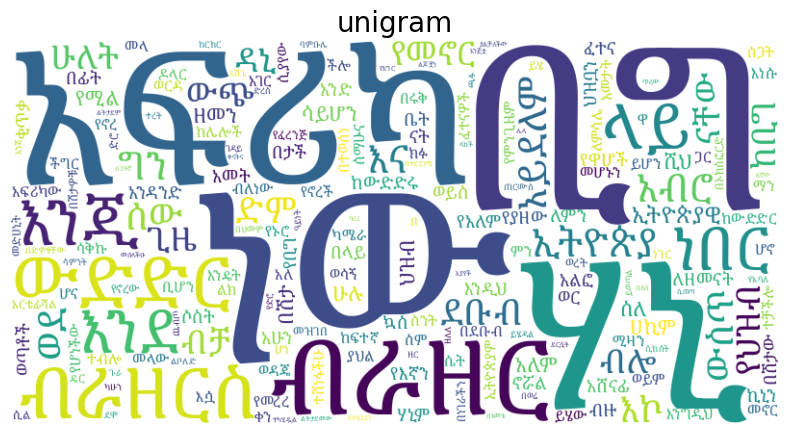

In [77]:
uni_gram.create_wordcloud("unigram")

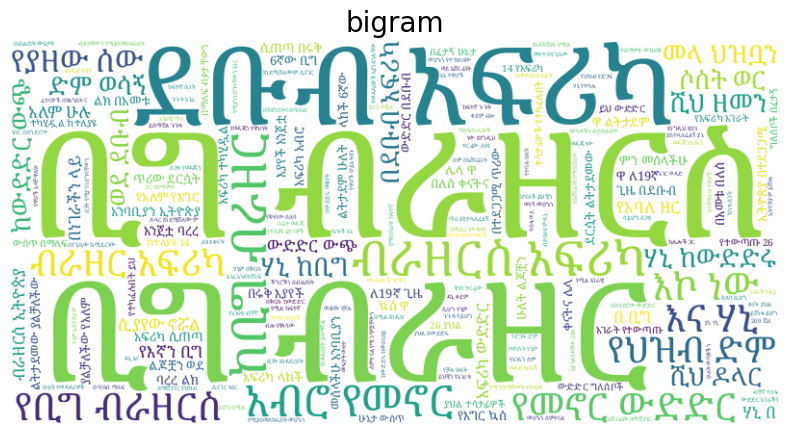

In [78]:
bi_gram.create_wordcloud("bigram")

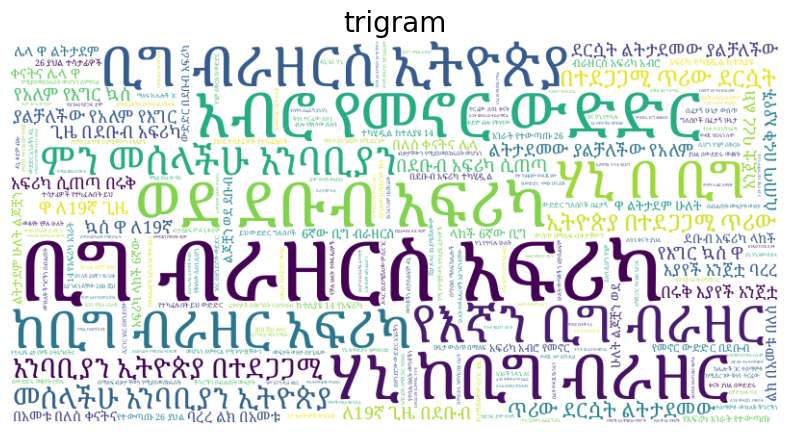

In [79]:
tri_gram.create_wordcloud("trigram")

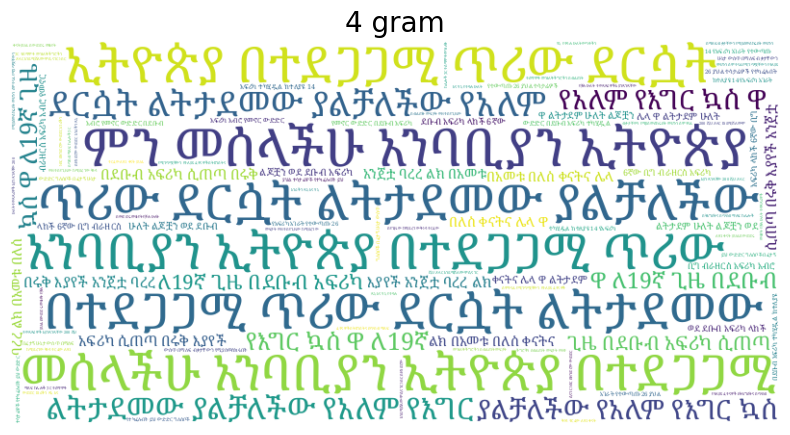

In [80]:
gram_4.create_wordcloud("4 gram")

In [ ]:
print("================== word cloud after Removing stop words =========")

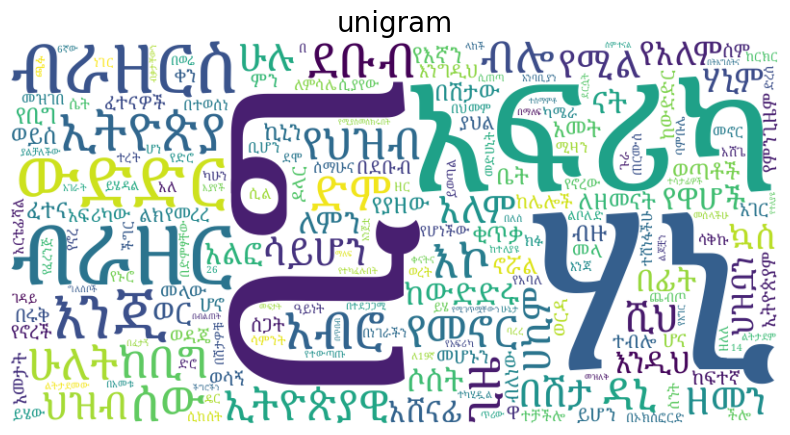

In [81]:
uni_gram_after.create_wordcloud("unigram")

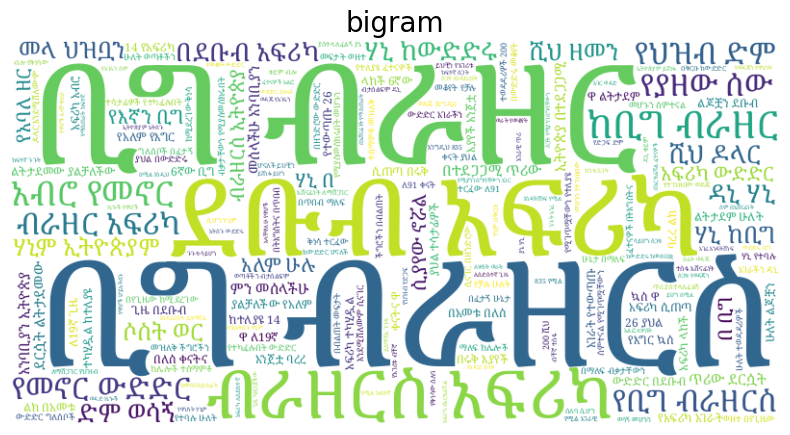

In [82]:
bi_gram_after.create_wordcloud("bigram")

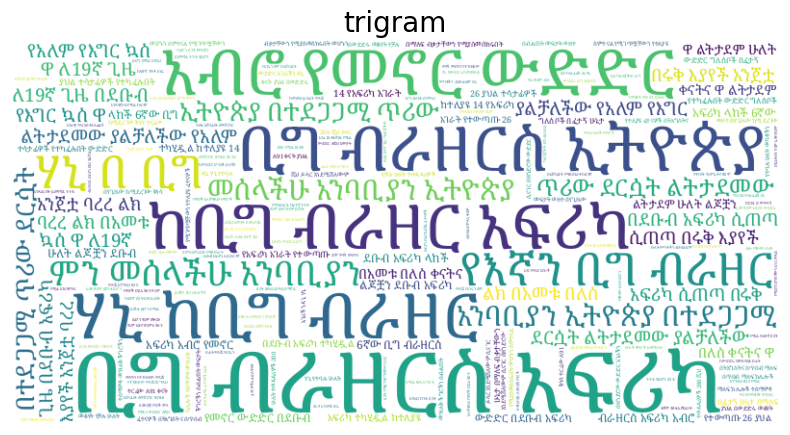

In [83]:
tri_gram_after.create_wordcloud("trigram")

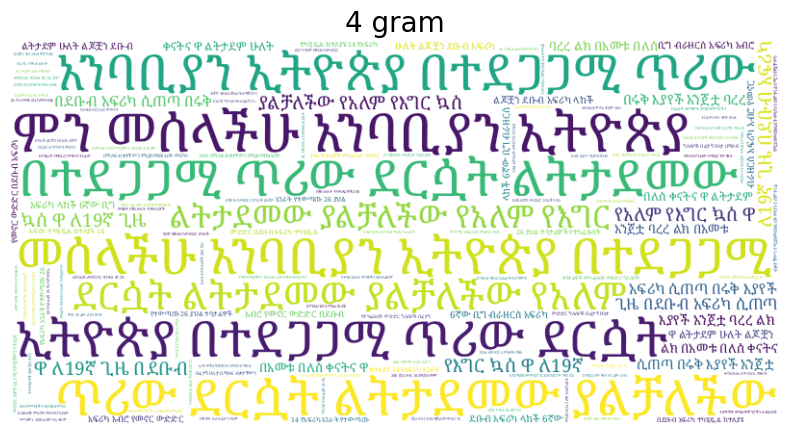

In [84]:
gram_4_after.create_wordcloud("4 gram")